In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
sns.set()

C:\Users\User\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Load data (pixels)
with np.load('cifar4-train.npz', allow_pickle=False) as data:
    cifar4 = dict(data.items())

X = cifar4['pixels'].astype(np.float32)
X = (X - 128) / 255  # center values between -0.5 and 0.5
y = cifar4['labels']

print(X.shape)
print(y.shape)

(5000, 3072)
(5000,)


In [3]:
# split to train, validation, test

# split data
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(
        X.reshape(-1, 32, 32, 3),
        y, stratify=y,
        test_size=1000, random_state=0
        )

X_tr, X_val, y_tr, y_val = train_test_split(
        X_tr,
        y_tr, stratify=y_tr,
        test_size=800, random_state=0
        )


(3200, 32, 32, 3)
(800, 32, 32, 3)
(1000, 32, 32, 3)


In [4]:
# Batch generator
def get_batches(X, y, batch_size):
    # Shuffle indices
    shuffled_idx = np.arange(len(y))
    np.random.shuffle(shuffled_idx)
    
    for i in range(0, len(y), batch_size):
        batch_idx = shuffled_idx[i: i+batch_size]
        yield X[batch_idx], y[batch_idx]

## Define Network: 
### - convolutional layer: 64 filters,  5x5 kernels, 2x2 stride, same padding, ReLU
### - max pooling: 2x2 pool size, 2x2 stride, same padding
### - convolutional layer: 64 filters,  3x3 kernels, 1x1 stride, same padding, ReLU
### - max pooling: 2x2 pool size, 2x2 stride, same padding
### - flatten output of maxpool (1024 units) and apply dropout (0.5), fully connected with a 256 unit layer
### - 256 unit layer with dropout (0.5) and ReLU, connected to output layer
### - Output layer: 4 units with softmax regression

In [5]:
# DEFINE GRAPH
    
graph = tf.Graph()

with graph.as_default():
    X = tf.placeholder(dtype=tf.float32, shape=[None, 32, 32, 3])
    y = tf.placeholder(dtype=tf.int32, shape=[None])
    
    # convolutional layer
    conv = tf.layers.conv2d(
            X,
            filters=64,
            kernel_size=(5, 5),
            strides=(2, 2),
            padding='SAME',
            activation=tf.nn.relu,
            kernel_initializer=tf.truncated_normal_initializer(
                    stddev=0.01, seed=0),
            name='conv'
            )
            
    
    # max pooling layer
    pool = tf.layers.max_pooling2d(
            conv, # convolution input
            pool_size=(2, 2), # pool size: 2
            strides=(2, 2), # Stride: 2
            padding='SAME'
            )

    
    # 2nd convolutional layer
    conv2 = tf.layers.conv2d(
            pool,
            filters=64,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding='SAME',
            activation=tf.nn.relu,
            kernel_initializer=tf.truncated_normal_initializer(
                    stddev=0.01, seed=0),
            name='conv2'
            )
            
    
    # 2nd max pooling layer
    pool2 = tf.layers.max_pooling2d(
            conv2, # convolution input
            pool_size=(2, 2), # pool size: 2
            strides=(2, 2), # Stride: 2
            padding='SAME'
            )
    
print(conv.shape)
print(pool.shape)
print(conv2.shape)
print(pool2.shape)

(?, 16, 16, 64)
(?, 8, 8, 64)
(?, 8, 8, 64)
(?, 4, 4, 64)


In [6]:
# flatten pool2
with graph.as_default():
    # automatically reshape output
    flat_output = tf.contrib.layers.flatten(pool2)
    
    # apply dropout to 1st flat layer
    training = tf.placeholder(dtype=tf.bool)
    # dropout
    flat_output = tf.layers.dropout(
        flat_output, rate=0.5, seed=0, training=training)

    # pass flat output to fully connected layer
    # output layer
    dense = tf.layers.dense(
            flat_output, 256,
            activation=tf.nn.relu,
            kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
            bias_initializer=tf.zeros_initializer(),
            name='dense'
            )
    
    dense = tf.layers.dropout(
        dense, rate=0.5, seed=0, training=training)
    

    logits = tf.layers.dense(
            dense, 4,
            activation=None,
            kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
            bias_initializer=tf.zeros_initializer(),
            name='output'
            )

In [7]:
# Define loss function and training operations
with graph.as_default():
    mean_ce = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                    labels=y, logits=logits
                    )
            )
            
    # Adam optimizer
    lr = tf.placeholder(dtype=tf.float32)
    gd = tf.train.AdamOptimizer(learning_rate=lr)
    
    # minimize cross-entropy
    train_op = gd.minimize(mean_ce)
    
    # compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))

## Train network

In [8]:
# TRAIN NETWORK
num_epochs = 100
learning_rate = 0.001
num_batches = 32

valid_acc_values = []

with tf.Session(graph=graph) as sess:
    # initialize variables
    sess.run(tf.global_variables_initializer())
    
    # set seed
    np.random.seed(0)
    
    # train several epochs
    for epoch in range(num_epochs):
        batch_acc = []
        
        for X_batch, y_batch in get_batches(X_tr, y_tr, num_batches):
            _, acc_value = sess.run([train_op, accuracy], feed_dict={
                    X: X_batch,
                    y: y_batch,
                    lr: learning_rate,
                    training: True
                    })
    
        batch_acc.append(acc_value)
        
        # evaluate validation accuracy
        valid_acc = sess.run(accuracy, feed_dict={
                X: X_val,
                y: y_val,
                training: False
                })
        valid_acc_values.append(valid_acc)
    
        # print progress
        print('Epoch {} - valid: {:.3f} train {:.3f} (mean)'.format(
                epoch+1, valid_acc, np.mean(batch_acc)
                )
            )
    
    # evaluate test accuracy
    test_acc = sess.run(accuracy, feed_dict={
            X: X_te,
            y: y_te,
            training: False
            })

Epoch 1 - valid: 0.510 train 0.500 (mean)
Epoch 2 - valid: 0.566 train 0.719 (mean)
Epoch 3 - valid: 0.592 train 0.656 (mean)
Epoch 4 - valid: 0.587 train 0.562 (mean)
Epoch 5 - valid: 0.652 train 0.625 (mean)
Epoch 6 - valid: 0.659 train 0.656 (mean)
Epoch 7 - valid: 0.664 train 0.781 (mean)
Epoch 8 - valid: 0.709 train 0.656 (mean)
Epoch 9 - valid: 0.711 train 0.594 (mean)
Epoch 10 - valid: 0.762 train 0.719 (mean)
Epoch 11 - valid: 0.754 train 0.656 (mean)
Epoch 12 - valid: 0.757 train 0.719 (mean)
Epoch 13 - valid: 0.760 train 0.812 (mean)
Epoch 14 - valid: 0.755 train 0.719 (mean)
Epoch 15 - valid: 0.759 train 0.781 (mean)
Epoch 16 - valid: 0.770 train 0.781 (mean)
Epoch 17 - valid: 0.766 train 0.938 (mean)
Epoch 18 - valid: 0.771 train 0.719 (mean)
Epoch 19 - valid: 0.780 train 0.875 (mean)
Epoch 20 - valid: 0.791 train 0.906 (mean)
Epoch 21 - valid: 0.794 train 0.844 (mean)
Epoch 22 - valid: 0.793 train 0.750 (mean)
Epoch 23 - valid: 0.803 train 0.781 (mean)
Epoch 24 - valid: 0.

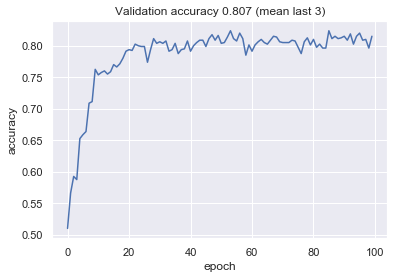

Test accuracy: 0.802


In [9]:
# plot validation accuracy after each epoch
plt.plot(valid_acc_values)
plt.title('Validation accuracy {:.3f} (mean last 3)'.format(
        np.mean(valid_acc_values[-3:])
        ))
    
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

print('Test accuracy: {:.3f}'.format(test_acc))